# HMB and MP Phenotype Derivation on UK Biobank RAP
Notebook for deriving Heavy Menstrual Bleeding and Menstrual Pain phenotypes for use in a Genome Wide Association Study (GWAS) on the UK Biobank RAP platform.        
*Cell outputs removed in compliance with Biobank data protection rules*

Author: **Adam El Kholy**    
Project P.I: **Dr. Gemma Sharp**    
Department of Psychology in collaboration with the Exeter Genetics Group,           
University of Exeter    
Last updated: 27/01/2025

In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from ukbython import ukbython
ukb = ukbython()

Running on database app103356_20241205153134...


# Heavy Menstrual Bleeding (HMB) phenotype

## ICD9, ICD10, Read2 and CTV3 codes

Getting ICD9 eids and dates

In [2]:
icd9s = [
    "6262",  # excessive or frequent menstruation
    "6270"   # premenopausal menorrhagia
]
hmb_icd9 = ukb.get_icd9(icd9s)

Searching 2 ICD9 codes...
Operation complete: Found 1592 matching records in 20.75 seconds.


Getting ICD10 eids and dates

In [3]:
icd10s = [
    "N92.0",  # excessive and frequent menstruation with regular cycle
    "N92.1",  # excessive and frequent menstruation with irregular cycle
    "N92.2",  # excessive menstruation at puberty
    "N92.4"   # excessive bleeding in the premenopausal period
]
hmb_icd10_hesin = ukb.get_icd10(icd10s)

Searching 4 ICD10 codes...
Found 14715 matching hospital records
Found 0 matching death records
Found 0 matching cancer records
Operation complete: Found 14715 matching records in 32.05 seconds.


Get GP clinical eids (Read2/CTV3 codes) and dates

In [4]:
Read2 = [
    "K5A0.11",  # climacteric menorrhagia
    "K592.00",  # excessive or frequent menstruation
    "K592z00",  # excessive or frequent menstruation nos
    "1573.11",  # h/o: heavy period
    "573.00",   # h/o: menorrhagia
    "K592012",  # heavy menstrual bleeding
    "K592011",  # heavy periods
    "K592000",  # menorrhagia
    "K5A6.00",  # perimenopausal menorrhagia
    "K5A0.00",  # premenopausal menorrhagia
    "K593.11",  # pubertal bleeding and menorrhagia
    "K592.12"   # hypermenorrhoea
]  

In [5]:
hmb_gp_clinical = ukb.get_gp_clinical(Read2)

Searching 12 Read2/CTV3 codes...
Operation complete: Found 14957 matching records in 5.64 seconds.


Checking ICD10 death records: no entries

In [6]:
# hmb_icd10_death = ukb.get_icd10_death(icd10s)
# hmb_icd10_death.count()

## Tranexamic acid phenotype

Treatment/medication code: field code: 20003  
Tranexamic acid n=699    
code: 1140861832

p20003_i{i}_a{a}
for  
0 to 3 inclusive instances, 
0 to 47 inclusive arrays with 
no dates

In [7]:
# all fields potentially containing a treatment code
columns = [f"p20003_i{i}_a{a}" for i in range(4) for a in range(48)]

# extract eids with treatment code for tranexamic acid
query = f"SELECT DISTINCT eid FROM `{ukb.database}`.`participant_0032` WHERE {' OR '.join([f'{col} = 1140861832' for col in columns])}"

tranex_df = ukb.spark.sql(query)

## Endometrial ablation phenotype

Endometrial ablation field code = 20004   
operations code = 1360

In [8]:
# all fields potentially containing a self-reported operation 
columns = [f"p20004_i{i}_a{a}" for i in range(4) for a in range(32)]

# concatenate all fields into one query to check for endometrial ablation
case_statements = [f"WHEN {col} = 1360 THEN '{col[8]},{col[11:]}'" for col in columns]
case_condition = " ".join(case_statements)

# extract (instance, array index)  for date querying
query = f"""
SELECT eid, 
       CASE {case_condition} 
       ELSE NULL 
       END AS idx
FROM `{ukb.database}`.`participant_0032`
WHERE { " OR ".join([f"{col} = 1360" for col in columns]) }
"""

endo_df = ukb.spark.sql(query)

Extracting fields for date of first diagnosis calculation:
- p20010: date of diagnosis
- p20011: age of diagnosis  

Extracting instance and array fields (4 instances with 32 arrays each):
- p20010 fields i0_a0 to i0_a9 are in p_0033, the rest are in p_0034
- p20011 fields are all in p_0034

In [9]:
# field names for querying p0033 and p0034, defined as above
p_33_selections = ["eid"] + [f"p20010_i0_a{a}" for a in range(10)]
p_34_selections = ["eid"] + [f"p20010_i{i}_a{a}" for i in range(4) for a in range(32) if int(i) != 0 or int(a) > 9] + [f"p20011_i{i}_a{a}" for i in range(4) for a in range(32)]

# querying p0033, p0034, and date of birth register
p_33_df = ukb.spark.sql(f"SELECT eid, {', '.join(p_33_selections)} FROM `{ukb.database}`.`participant_0033`")
p_34_df = ukb.spark.sql(f"SELECT eid, {', '.join(p_34_selections)} FROM `{ukb.database}`.`participant_0034`")
dob_df = ukb.spark.sql(f"SELECT eid, p34 FROM  `{ukb.database}`.`participant_0001`")

# inner joins to create master dataframe
main_df = endo_df.join(p_33_df, on="eid", how="inner")
main_df = main_df.join(p_34_df, on="eid", how="inner")
main_df = main_df.join(dob_df, on="eid", how="inner")

In [10]:
# convert spark DataFrame into Python list
endo_list = main_df.collect()

In [11]:
endo_ages_list = []

# enumerate endometrial ablation eids
for entry in endo_list:
    # extract instance, array indexes
    i, a = entry["idx"].split(",")

    # get date of birth
    dob = entry["p34"]

    # get age and date of diagnosis
    age = entry[f"p20011_i{i}_a{a}"]
    date = entry[f"p20010_i{i}_a{a}"]

    # convert date to age
    date_to_age = round(date - dob, 1)

    # validation for calculating correct min value
    if age <= 0:
        age = 10000
    if date_to_age <= 0:
        date_to_age = 10000
    first_diagnosis_age = min(age, date_to_age)

    if first_diagnosis_age == 10000:
        first_diagnosis_age = None

    endo_ages_list.append([int(entry["eid"]), first_diagnosis_age])

# print("\n".join([str(e) for e in endo_ages_list[:10]]))
# print(len(endo_ages_list))

In [12]:
endo_ages_df = ukb.spark.createDataFrame(endo_ages_list, schema=['eid', 'first_diagnosis_age'])

## Final HMB phenotype

Derived variables:   
• hmb_ever <- any diagnosis ever recorded vs no diagnosis ever recorded    
• hmb_incident_ado <- any diagnosis before or equal to age 19 vs no diagnosis before or equal to age 19    
• hmb_incident_mid <- any diagnosis between age 20-40 (inclusive) vs no diagnosis between age 20-40 (inclusive)    
• hmb_incident_meno <- any diagnosis between age 40-60 (inclusive) vs no diagnosis between age 40-60 (inclusive)    

In [13]:
# join all dates entries into one table
all_dates_df = hmb_icd9.join(hmb_icd10_hesin.withColumnRenamed("diagnosis_date", "icd10_diagnosis_date"), on="eid", how="outer")
all_dates_df = all_dates_df.join(hmb_gp_clinical, on="eid", how="outer")

In [14]:
# get the earliest date across all fields
first_date_df = all_dates_df.withColumn('first_diagnosis_date', F.least(F.col('diagnosis_date'), F.col('icd10_diagnosis_date'), F.col('event_dt')))
first_date_df = first_date_df.select("eid", F.year("first_diagnosis_date").alias("first_diagnosis_date"))

In [15]:
# join dobs with first diagnosis dates
dates_to_ages_df = first_date_df.join(dob_df, on="eid", how="inner")

# subtract date of birth from diagnosis date to get age at diagnosis
dates_to_ages_df = dates_to_ages_df.withColumn(
    "first_diagnosis_age_unfiltered", 
    dates_to_ages_df["first_diagnosis_date"] - dates_to_ages_df["p34"]
)

# replace ages <= 0 with null in a column 
dates_to_ages_df = dates_to_ages_df.withColumn(
    'first_diagnosis_age_',
    F.when(F.col('first_diagnosis_age_unfiltered') <= 0, F.lit(None))  # if value <= 0, set it to null
    .otherwise(F.col('first_diagnosis_age_unfiltered'))                # otherwise keep the original value
)

all_ages_df = dates_to_ages_df.select("eid", "first_diagnosis_age_")

In [16]:
# finally get mininum age of diagnosis from [min(ICD9, ICD10, Read2 codes)] , [endometrial ablation]
combined_ages_df = all_ages_df.join(endo_ages_df, on="eid", how="outer")
final_ages_df = combined_ages_df.withColumn('diagnosis_age', F.least(F.col('first_diagnosis_age_'), F.col('first_diagnosis_age')))
final_ages_df = final_ages_df.select("eid", "diagnosis_age")

In [17]:
# finally join tranxamic acid participants (for whom no dates are available)
hmb_phenotype_df = final_ages_df.join(tranex_df, on="eid", how="outer")

## Filtering female participants only

In [18]:
query = f"SELECT DISTINCT eid FROM `{ukb.database}`.`participant_0001` WHERE p31 == 0"
females_df = ukb.spark.sql(query)
hmb_phenotype_df = females_df.join(hmb_phenotype_df, on="eid", how="inner")

## Deriving HMB variables
• hmb_ever <- any diagnosis ever recorded vs no diagnosis ever recorded    
• hmb_incident_ado <- any diagnosis before or equal to age 19 vs no diagnosis before or equal to age 19    
• hmb_incident_mid2 <- with a different age at first diagnosis range: 20 <= age <= 40          
• hmb_incident_meno2 <- with a different age at first diagnosis range: age >= 40    
• filter out over 60s

In [19]:
def derive_variables(df, name):
    phenotype_df = df.withColumn(
        "diagnosis_age",
        F.when(F.col("diagnosis_age") < 0, None).otherwise(F.col("diagnosis_age")),
    )
    # age ≤ 19
    phenotype_df = phenotype_df.withColumn(
        f"{name}_incident_ado",
        F.when(
            (F.col("diagnosis_age") > 0) & (F.col("diagnosis_age") <= 19), F.lit(1)
        ).otherwise(F.lit(0)),
    )
    # 19 < age ≤ 40
    phenotype_df = phenotype_df.withColumn(
        f"{name}_incident_mid2",
        F.when(
            (F.col("diagnosis_age") > 19) & (F.col("diagnosis_age") <= 40), F.lit(1)
        ).otherwise(F.lit(0)),
    )
    # 40 < age ≤ 60
    phenotype_df = phenotype_df.withColumn(
        f"{name}_incident_meno2",
        F.when(
            (F.col("diagnosis_age") > 40)  & (F.col("diagnosis_age") <= 60), F.lit(1)
        ).otherwise(F.lit(0)),
    )
    # over 60
    phenotype_df = phenotype_df.withColumn(
        f"{name}_over60",
        F.when(F.col("diagnosis_age") > 60, F.lit(1)).otherwise(F.lit(0)),
    )
    # ever variable: filter out over 60s
    phenotype_df = phenotype_df.withColumn(
        f"{name}_ever",
        F.when(F.col(f"{name}_over60") == 1, F.lit(0)).otherwise(F.lit(1)),
    )


    # calculate summary statistics
    summary_stats = (
        phenotype_df.agg(
            F.sum(F.col(f"{name}_ever")).alias("n"),
            F.avg(
                F.when((F.col("diagnosis_age").isNotNull()) & (F.col(f"{name}_ever") == 1), F.col("diagnosis_age"))
            ).alias("avg_diagnosis_age"),
            F.sum(
                F.when(F.col("diagnosis_age").isNull(), 1).otherwise(0)
            ).alias("null_ages"),
            F.sum(F.col(f"{name}_incident_ado")).alias(f"{name}_incident_ado_count"),
            F.sum(F.col(f"{name}_incident_mid2")).alias(f"{name}_incident_mid_count2"),
            F.sum(F.col(f"{name}_incident_meno2")).alias(f"{name}_incident_meno_count2"),
            F.sum(F.col(f"{name}_over60")).alias(f"{name}_over60_count"),
        )
        .collect()[0]
        .asDict()
    )

    summary_stats["name"] = name

    return phenotype_df, summary_stats


In [20]:
def print_summary_statistics(counts, n=None):
    if not n:
        n = counts["n"]
    
    name = counts["name"]
    percent = lambda x: (x / n) * 100
    print(f"---------------------------- {name} summary statistics ----------------------------")

    categories = [
        ("age ≤ 19", counts[f"{name}_incident_ado_count"]),
        ("19 < age ≤ 40", counts[f"{name}_incident_mid_count2"]),
        ("40 < age ≤ 60", counts[f"{name}_incident_meno_count2"]),
        ("age unavailable", counts["null_ages"])
    ]

    print(f"{'Age Category':<20} {'Count':<10} {'Percentage':<12}")
    print("-" * 50)
    
    for category, count in categories:
        print(f"{category:<20} {count:<10} {percent(count):.2f}%")
        
    print("--------------------------------------------------------------------------------")
    print(f"{name} diagnoses over 60 (excluded): {counts[f'{name}_over60_count']}")  
    print(f"total women with {name}: {n}")
    print(f"average diagnosis age: {counts['avg_diagnosis_age']:.2f}")


In [21]:
# plot age categorisation pie chart
def plot_counts_pie_chart(counts):
    name = counts["name"]
    percent = lambda x: (x / counts["n"]) * 100

    labels = ["age ≤ 19", "19 < age ≤ 40", "40 < age ≤ 60",  "age unavailable"]
    frequencies = [
        counts[f'{name}_incident_ado_count'],
        counts[f'{name}_incident_mid_count2'],
        counts[f'{name}_incident_meno_count2'],
        counts['null_ages']
    ]

    colors = ['gold', 'lightblue', 'lightcoral', 'limegreen'] 

    plt.figure(figsize=(8, 6))
    wedges, texts = plt.pie(
        frequencies,
        labels=None,        
        colors=colors,
        startangle=140,
        wedgeprops={'edgecolor': 'black'}  
    )

    plt.legend(
        labels=[f"{label} ({percent(frequencies):.2f}%)" for label, frequencies in zip(labels, frequencies)], 
        title="Age Groups", 
        loc="center left", 
        bbox_to_anchor=(1, 0.5), 
        fontsize=12,              
        title_fontsize=14        
    )

    plt.title(f"Age distribution for {name}", fontsize=18)
    plt.show()

In [22]:
hmb_phenotype_df_, hmb_counts = derive_variables(hmb_phenotype_df, "hmb")

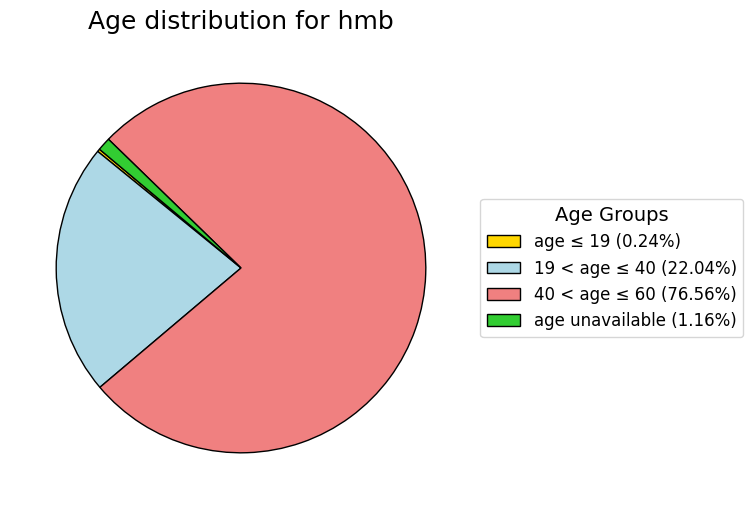

---------------------------- hmb summary statistics ----------------------------
Age Category         Count      Percentage  
--------------------------------------------------
age ≤ 19             72         0.24%
19 < age ≤ 40        6536       22.04%
40 < age ≤ 60        22704      76.56%
age unavailable      343        1.16%
--------------------------------------------------------------------------------
hmb diagnoses over 60 (excluded): 114
total women with hmb: 29655
average diagnosis age: 44.69
% of women with hmb: 10.86%


In [23]:
plot_counts_pie_chart(hmb_counts)
print_summary_statistics(hmb_counts)
print(f"% of women with hmb: {((hmb_counts['n'] / 273157) * 100):.2f}%")

## Control group

Control: Any females with EHR data

In [24]:
# filter female eids from all EHR tables
filter_females = lambda df: females_df.join(df, on="eid", how="inner")

# females with icd9 or icd10 codes
icd_df = filter_females(ukb.spark.sql(f"SELECT DISTINCT eid FROM `{ukb.database}`.`hesin_diag` WHERE diag_icd9 IS NOT NULL OR diag_icd10 IS NOT NULL"))
icd_df.count() # 245942

245942

In [25]:
# females with gp clinical data
gp_df = filter_females(ukb.spark.sql(f"SELECT DISTINCT eid FROM `{ukb.database}`.`gp_clinical` WHERE read_2 IS NOT NULL OR read_3 IS NOT NULL"))
gp_df.count() # 125700

125700

In [26]:
# females with death records
death_df = filter_females(ukb.spark.sql(f"SELECT DISTINCT eid FROM `{ukb.database}`.`death_cause` WHERE cause_icd10 IS NOT NULL"))
death_df.count() # 18191

18191

In [27]:
# females with OPCS codes
opcs_df = filter_females(ukb.spark.sql(f"SELECT DISTINCT eid FROM `{ukb.database}`.`hesin_oper` WHERE oper3 IS NOT NULL OR oper4 IS NOT NULL"))
opcs_df.count() # 245197

245197

In [28]:
# females with cancer records
case_statements = [f"p40006_i{i} IS NOT NULL" for i in range(22)]
case_condition = " OR ".join(case_statements)
query = f"SELECT DISTINCT eid FROM `{ukb.database}`.`participant_0073` WHERE {case_condition}"
cancer_df = filter_females(ukb.spark.sql(query))
cancer_df.count() # 63447

63447

In [29]:
# join all EHR recorded females to make control DF
control_df = icd_df.join(gp_df, on="eid", how="outer")
control_df = control_df.join(death_df, on="eid", how="outer")
control_df = control_df.join(opcs_df, on="eid", how="outer")
control_df = control_df.join(cancer_df, on="eid", how="outer")
control_df.count() # 258798

258798

## HMB phenotype with control

In [30]:
hmb_final_df = control_df.join(hmb_phenotype_df_, on="eid", how="outer")
hmb_final_df = hmb_final_df.withColumn("hmb_ever", F.when(F.col("hmb_ever").isNull(), F.lit(0)).otherwise(F.col("hmb_ever")))
hmb_final_df = hmb_final_df.withColumnRenamed("diagnosis_age", "hmb_diagnosis_age")
hmb_final_df = hmb_final_df.select(*["eid", "hmb_ever", "hmb_diagnosis_age", "hmb_incident_ado", "hmb_incident_mid2", "hmb_incident_meno2", "hmb_over60"])
hmb_final_df.count()

258908

# Menstrual Pain (MP) phenotype

## Self-report questionnaire

- p21050 found in participant_0042             
- p21026 found in participant_0042        
   

Self-report questionnaire (available for MP only - not HMB)         
• 21050: During the past 3 months, how much have you been bothered by menstrual cramps or other problems with your periods? [n bothered a lot =1083]            
-600	Not bothered at all       
-601	Bothered a little       
-602	Bothered a lot         
-818	Prefer not to answer         
-313	Not applicable         

• 21026: Did this discomfort or pain occur only during your menstrual bleeding and not at other times? [n yes =1121]          
1	Yes    
0	No     
-818	Prefer not to answer     
-313	Not applicable         

Participants answering “bothered a lot” to 21050 and “yes” to 21026 should be coded as a case!          

In [32]:
# menstrual pain self report variable
query = f"SELECT eid, p21050, p21026 FROM `{ukb.database}`.`participant_0042` WHERE p21050 == -602 AND p21026 == 1"
mp_selfrep_df = ukb.spark.sql(query)
mp_selfrep_df = mp_selfrep_df.select("eid")

## Mefenamic acid

Mefenamic acid code = 1140871542

In [33]:
# all fields potentially containing a treatment code
columns = [f"p20003_i{i}_a{a}" for i in range(4) for a in range(48)]

# extract eids with treatment code for mefenamic acid
query = f"SELECT DISTINCT eid FROM `{ukb.database}`.`participant_0032` WHERE {' OR '.join([f'{col} = 1140871542' for col in columns])}"

mefenamic_df = ukb.spark.sql(query)

## ICD0, ICD10, Read2 and CTV3 Codes

In [34]:
icd9 = ["6253"]  # dysmenorrhoea
mp_icd9 = ukb.get_icd9(icd9)

Searching 1 ICD9 codes...
Operation complete: Found 313 matching records in 8.86 seconds.


In [35]:
ICD10 = [
    "N94.4",  # primary dysmenorrhoea
    "N94.5",  # secondary dysmenorrhoea
    "N94.6"   # dysmenorrhoea, unspecified
]
mp_icd10_hesin = ukb.get_icd10_hesin(ICD10)

In [36]:
Read2 = [
    "Eu45y11",  # psychogenic dysmenorrhoea
    "K583.00",  # dysmenorrhoea
    "1574.00",  # h/o: dysmenorrhoea
    "1574.11",  # h/o: painful periods
    "K583.11",  # painful menorrhoea
    "K583.12",  # painful menstruation
    "K583.13",  # period pains
    "K583000",  # primary dysmenorrhoea
    "E265200",  # psychogenic dysmenorrhea
    "K583100",  # secondary dysmenorrhoea
    "K583.14"   # spasmodic dysmenorrhoea
]

In [37]:
mp_gp_clinical = ukb.get_gp_clinical(Read2)

Searching 11 Read2/CTV3 codes...
Operation complete: Found 1510 matching records in 5.46 seconds.


## Final MP phenotype

In [38]:
# join all dates entries into one table
all_dates_df = mp_icd9.join(mp_icd10_hesin.withColumnRenamed("diagnosis_date", "icd10_diagnosis_date"), on="eid", how="outer")
all_dates_df = all_dates_df.join(mp_gp_clinical, on="eid", how="outer")

In [39]:
# get the earliest date across all fields
first_date_df = all_dates_df.withColumn('first_diagnosis_date', F.least(F.col('diagnosis_date'), F.col('icd10_diagnosis_date'), F.col('event_dt')))
first_date_df = first_date_df.select("eid", F.year("first_diagnosis_date").alias("first_diagnosis_date"))

In [40]:
# join dobs with first diagnosis dates
dates_to_ages_df = first_date_df.join(dob_df, on="eid", how="inner")

# subtract date of birth from diagnosis date to get age at diagnosis
dates_to_ages_df = dates_to_ages_df.withColumn(
    "first_diagnosis_age_unfiltered", 
    dates_to_ages_df["first_diagnosis_date"] - dates_to_ages_df["p34"]
)

# replace ages <= 0 with null in a column 
dates_to_ages_df = dates_to_ages_df.withColumn(
    'diagnosis_age',
    F.when(F.col('first_diagnosis_age_unfiltered') <= 0, F.lit(None))  # if value <= 0, set it to null
    .otherwise(F.col('first_diagnosis_age_unfiltered'))                # otherwise keep the original value
)

all_ages_df = dates_to_ages_df.select("eid", "diagnosis_age")

In [41]:
# finally join mefenamic acid and self reoport participants (for whom no dates available)
mp_phenotype_df = all_ages_df.join(mefenamic_df, on="eid", how="outer")
mp_phenotype_df = mp_phenotype_df.join(mp_selfrep_df, on="eid", how="outer")

## Filtering female participants only

In [42]:
mp_phenotype_df = females_df.join(mp_phenotype_df, on="eid", how="inner")

## Deriving MP variables

Derived variables         
• mp_ever <- any diagnosis ever recorded vs no diagnosis ever recorded        
• mp_incident_ado <- any diagnosis before or equal to age 19 vs no diagnosis before or equal to age 19         
• mp_incident_mid <- any diagnosis between age 20-44 (inclusive) vs no diagnosis between age 20-44 (inclusive)      
• mp_incident_meno <- any diagnosis between age 45-60 (inclusive) vs no diagnosis between age 45-60 (inclusive)      



In [43]:
mp_phenotype_df_, mp_counts = derive_variables(mp_phenotype_df, "mp")

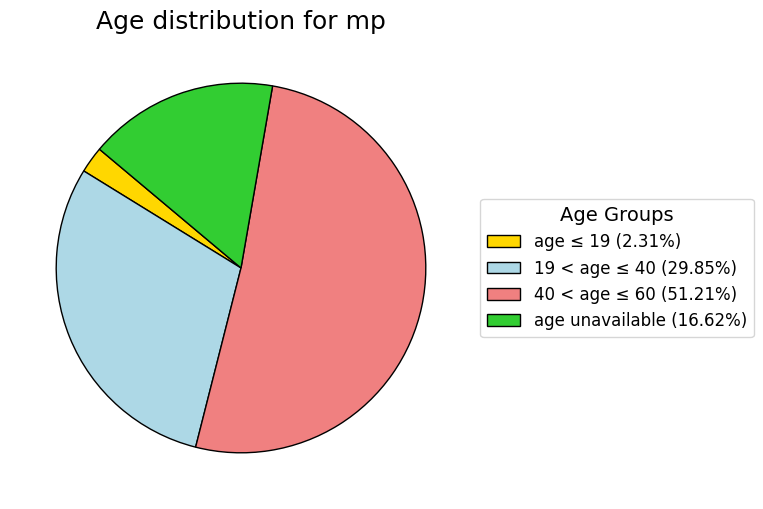

---------------------------- mp summary statistics ----------------------------
Age Category         Count      Percentage  
--------------------------------------------------
age ≤ 19             100        2.31%
19 < age ≤ 40        1291       29.85%
40 < age ≤ 60        2215       51.21%
age unavailable      719        16.62%
--------------------------------------------------------------------------------
mp diagnoses over 60 (excluded): 20
total women with mp: 4325
average diagnosis age: 41.14
% of women with mp: 1.58%


In [69]:
plot_counts_pie_chart(mp_counts)
print_summary_statistics(mp_counts)
print(f"% of women with mp: {((mp_counts['n'] / 273157) * 100):.2f}%")

## MP phenotype with control group

In [45]:
mp_final_df = control_df.join(mp_phenotype_df_, on="eid", how="outer")
mp_final_df = mp_final_df.withColumn("mp_ever", F.when(F.col("mp_ever").isNull(), F.lit(0)).otherwise(F.col("mp_ever")))
mp_final_df = mp_final_df.withColumnRenamed("diagnosis_age", "mp_diagnosis_age")
mp_final_df = mp_final_df.select(*["eid", "mp_ever", "mp_diagnosis_age", "mp_incident_ado", "mp_incident_mid2", "mp_incident_meno2", "mp_over60"])
mp_final_df.count()

258842

# Final HMB and MP phenotype 

In [46]:
final_phenotype_df = hmb_final_df.join(mp_final_df, on="eid", how="outer")
final_phenotype_df.count()

258949

In [47]:
query = f"SELECT DISTINCT eid FROM `{ukb.database}`.`participant_0001`"
whole_cohort = ukb.spark.sql(query)
whole_cohort.count()

502131

In [48]:
# join the entire cohort (inc. males)
final_phenotype_df = final_phenotype_df.join(whole_cohort, on="eid", how="outer")
final_phenotype_df.count()

502131

In [ ]:
from pyspark.sql.functions import col

# redundancy check: filter out withdrawn participants
with open("withdrawn_participants.csv", "r") as f:
    withdrawn_eids = set(f.read().splitlines())

final_phenotype_df = final_phenotype_df.filter(~col("eid").isin(withdrawn_eids))
final_phenotype_df.show()
final_phenotype_df.count()

Final conversion to correct file format for GWAS

In [ ]:
import pandas as pd

# final conversion to pandas dataframe
hmb_gwas = final_phenotype_df.select("eid", "hmb_ever")
hmb_pdf = hmb_gwas.toPandas()
hmb_pdf.columns = ["FID", "hmb_ever"]
hmb_pdf["IID"] = hmb_pdf["FID"]

# convert hmb_ever to 0, 1, or NA
hmb_pdf["hmb_ever"] = hmb_pdf["hmb_ever"].apply(
    lambda x: "NA" if pd.isnull(x) else int(x)
)

hmb_pdf = hmb_pdf[["FID", "IID", "hmb_ever"]]
print(hmb_pdf.head())

In [51]:
def write_df_to_file(pdf, filename):
    pdf.to_csv(filename, sep="\t", index=False, encoding="utf-8")
    print(f"{filename} saved successfully")
    
write_df_to_file(hmb_pdf, "hmb_phenotype.tsv")

hmb_phenotype.tsv saved successfully


In [ ]:
# final conversion to pandas dataframe
mp_gwas = final_phenotype_df.select("eid", "mp_ever")
mp_pdf = mp_gwas.toPandas()
mp_pdf.columns = ["FID", "mp_ever"]
mp_pdf["IID"] = mp_pdf["FID"]

# convert mp_ever to 0, 1, or NA
mp_pdf["mp_ever"] = mp_pdf["mp_ever"].apply(
    lambda x: "NA" if pd.isnull(x) else int(x)
)

mp_pdf = mp_pdf[["FID", "IID", "mp_ever"]]
print(mp_pdf.head())

In [53]:
write_df_to_file(mp_pdf, "mp_phenotype.tsv")

mp_phenotype.tsv saved successfully


## Removing existing conditions for sensitivity analysis

Collecting participants with exclusion criteria for sensitivity analysis:

In [54]:
filter_females = lambda df: females_df.join(df, on="eid", how="inner")

In [55]:
icd10s = [f"N80.{i}" for i in range(1,10)] # Endometriosis N80.1 – N80.9
endometriosis_df = ukb.get_icd10(icd10s)
endometriosis_df = filter_females(endometriosis_df).select("eid")
endometriosis_df.count()

Searching 9 ICD10 codes...
Found 3353 matching hospital records
Found 1 matching death records
Found 0 matching cancer records
Operation complete: Found 3353 matching records in 26.31 seconds.


3353

In [56]:
icd10s = ["E28.2"] # Polycystic Ovary Syndrome E28.2
POS_df = ukb.get_icd10(icd10s)
POS_df = filter_females(POS_df).select("eid")
POS_df.count()

Searching 1 ICD10 codes...
Found 444 matching hospital records
Found 0 matching death records
Found 0 matching cancer records
Operation complete: Found 444 matching records in 26.91 seconds.


442

In [57]:
icd10s = [f"D25.{i}" for i in range(10)]  # Uterine Leiomyoma D25
uterine_leiomyoma_df = ukb.get_icd10(icd10s)
uterine_leiomyoma_df = filter_females(uterine_leiomyoma_df).select("eid")
uterine_leiomyoma_df.count()

Searching 10 ICD10 codes...
Found 15764 matching hospital records
Found 1 matching death records
Found 0 matching cancer records
Operation complete: Found 15764 matching records in 24.33 seconds.


15763

In [58]:
icd10s = ["N84.0"] # Uterine Polyps N84.0
uterine_polyps_df = ukb.get_icd10(icd10s)
uterine_polyps_df = filter_females(uterine_polyps_df).select("eid")
uterine_polyps_df.count()

Searching 1 ICD10 codes...
Found 12171 matching hospital records
Found 0 matching death records
Found 0 matching cancer records
Operation complete: Found 12171 matching records in 26.01 seconds.


12171

In [59]:
icd10s = ["N80.0"] # Adenomyosis N80.0
adenomyosis_df = ukb.get_icd10(icd10s)
adenomyosis_df = filter_females(adenomyosis_df).select("eid")
adenomyosis_df.count()

Searching 1 ICD10 codes...
Found 2692 matching hospital records
Found 0 matching death records
Found 0 matching cancer records
Operation complete: Found 2692 matching records in 25.44 seconds.


2692

In [60]:
icd10s = [f"N7{i}.{a}" for i in range(8) for a in range(10)] # Pelvic Inflammatory Disease N70 – N77
PID_df = ukb.get_icd10(icd10s)
PID_df = filter_females(PID_df).select("eid")
PID_df.count()

Searching 80 ICD10 codes...
Found 8113 matching hospital records
Found 9 matching death records
Found 0 matching cancer records
Operation complete: Found 8118 matching records in 26.01 seconds.


8114

In [61]:
excluded_df = endometriosis_df.join(POS_df, on="eid", how="outer")
excluded_df = excluded_df.join(uterine_leiomyoma_df, on="eid", how="outer")
excluded_df = excluded_df.join(uterine_polyps_df, on="eid", how="outer")
excluded_df = excluded_df.join(adenomyosis_df, on="eid", how="outer")
excluded_df = excluded_df.join(PID_df, on="eid", how="outer")

In [62]:
excluded_df.count()

33739

Excluding participants and deriving variables:

In [65]:
excluded_hmb_phenotype_df = hmb_phenotype_df.join(excluded_df, on="eid", how="anti")
excluded_hmb_phenotype_df.count()

20218

In [66]:
excluded_mp_phenotype_df = mp_phenotype_df.join(excluded_df, on="eid", how="anti")
excluded_mp_phenotype_df.count()

2861

In [67]:
excluded_hmb_phenotype_df_, excluded_hmb_counts = derive_variables(excluded_hmb_phenotype_df, "hmb_excluded")
print_summary_statistics(excluded_hmb_counts)

---------------------------- hmb_excluded summary statistics ----------------------------
Age Category         Count      Percentage  
--------------------------------------------------
age ≤ 19             60         0.30%
19 < age ≤ 40        4845       24.04%
40 < age ≤ 60        14969      74.26%
age unavailable      283        1.40%
--------------------------------------------------------------------------------
hmb_excluded diagnoses over 60 (excluded): 61
total women with hmb_excluded: 20157
average diagnosis age: 44.22


In [68]:
excluded_mp_phenotype_df_, excluded_mp_counts = derive_variables(excluded_mp_phenotype_df, "mp_excluded")
print_summary_statistics(excluded_mp_counts)

---------------------------- mp_excluded summary statistics ----------------------------
Age Category         Count      Percentage  
--------------------------------------------------
age ≤ 19             87         3.06%
19 < age ≤ 40        917        32.23%
40 < age ≤ 60        1312       46.12%
age unavailable      529        18.59%
--------------------------------------------------------------------------------
mp_excluded diagnoses over 60 (excluded): 16
total women with mp_excluded: 2845
average diagnosis age: 40.19


## Final summary statistics

Both <- hmb_ever==1 AND mp_ever==1

HMBonly <- hmb_ever==1 AND mp_ever==0

MPonly <- hmb_ever==0 AND mp_ever==1

Neither <- hmb_ever==0 AND mp_ever==0

If either hmb_ever or mp_ever is missing, the participant can be coded as missing for this variable.

In [70]:
final_summary_stats = (
    final_phenotype_df.agg(
        F.sum(
            F.when((F.col("hmb_ever") == 1) & (F.col("mp_ever") == 1), 1).otherwise(0),
        ).alias("both"),
        F.sum(
            F.when((F.col("hmb_ever") == 1) & (F.col("mp_ever") == 0), 1).otherwise(0),
        ).alias("hmb_only"),
        F.sum(
            F.when((F.col("hmb_ever") == 0) & (F.col("mp_ever") == 1), 1).otherwise(0),
        ).alias("mp_only"),
        F.sum(
            F.when((F.col("hmb_ever") == 0) & (F.col("mp_ever") == 0), 1).otherwise(0),
        ).alias("neither"),
    )
    .collect()[0]
    .asDict()
)

In [71]:
for key, value in final_summary_stats.items():
    print(f"{key}: {value}")

both: 2578
hmb_only: 26971
mp_only: 1706
neither: 227546


Final summary statistics for participants with known disorders

In [72]:
known_disorder_df = final_phenotype_df.join(excluded_df, on="eid", how="inner")

In [75]:
known_disorder_final_summary_stats = (
    known_disorder_df.agg(
        F.sum(
            F.when((F.col("hmb_ever") == 1) & (F.col("mp_ever") == 1), 1).otherwise(0),
        ).alias("both"),
        F.sum(
            F.when((F.col("hmb_ever") == 1) & (F.col("mp_ever") == 0), 1).otherwise(0),
        ).alias("hmb_only"),
        F.sum(
            F.when((F.col("hmb_ever") == 0) & (F.col("mp_ever") == 1), 1).otherwise(0),
        ).alias("mp_only"),
        F.sum(
            F.when((F.col("hmb_ever") == 0) & (F.col("mp_ever") == 0), 1).otherwise(0),
        ).alias("neither"),
    )
    .collect()[0]
    .asDict()
)

In [76]:
for key, value in known_disorder_final_summary_stats.items():
    print(f"{key}: {value}")

both: 1094
hmb_only: 8404
mp_only: 386
neither: 23855


# Age distribution curve

In [77]:
import seaborn as sns

# filter out rows where 'diagnosis_age' is null
filtered_ages = (
    mp_phenotype_df.filter(mp_phenotype_df["diagnosis_age"].isNotNull())
    .select("diagnosis_age")
    .rdd.flatMap(lambda x: x)
    .collect()
)

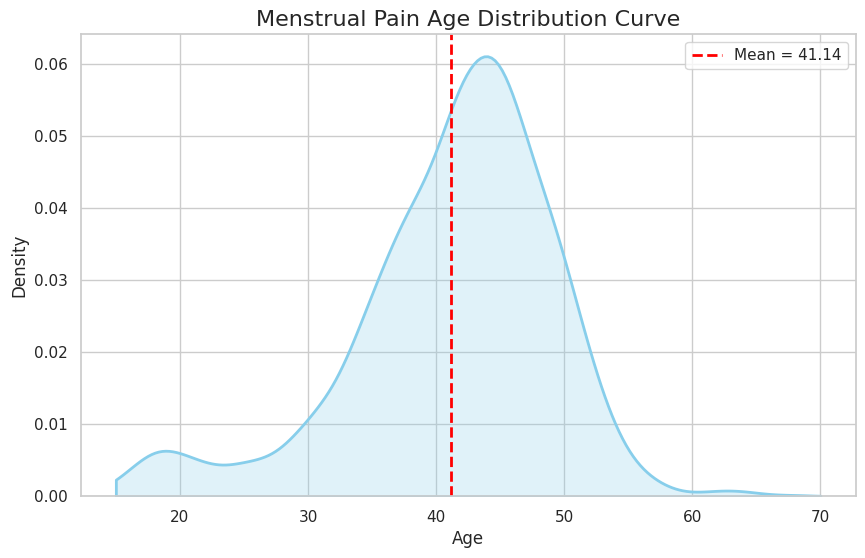

In [78]:
sns.set_theme(style="whitegrid")  
plt.figure(figsize=(10, 6))  

# calculate average diagnosis age and plot age distribution curve
avg_diagnosis_age = mp_counts["avg_diagnosis_age"]

sns.kdeplot(filtered_ages, fill=True, clip=(15, 70), color='skyblue', linewidth=2)
plt.axvline(avg_diagnosis_age, color='red', linestyle='--', linewidth=2, label=f"Mean = {avg_diagnosis_age:.2f}")

plt.title("Menstrual Pain Age Distribution Curve", fontsize=16)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.show()